Documentation for the data can be found [here](http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt). 

I take a lot of inspiration from:
* [The Kaggle Learn: Machine Learning lessons by Dan Becker](https://www.kaggle.com/learn/machine-learning)
*  [Stacked Regressions by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [Comprehensive data exploration with Python by  Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

In [1]:
import numpy as np 
import pandas as pd
import sklearn

import os
print(os.listdir("./data"))


['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
import seaborn as sns
import matplotlib as plt
from plotnine import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.stats import norm    # used in plotting

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [3]:
## In Kaggle
#trainData = pd.read_csv("../input/train.csv")
#testData = pd.read_csv("../input/test.csv")

## Local
trainData = pd.read_csv("./data/train.csv")
testData = pd.read_csv("./data/test.csv")

testID = testData.Id
trainData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Imputation

The documentation refers to 5 outliers in this dataset, of which 3 are true outliers. A plot of sale price against ground living area is encouraged. Below, 4 clear outliers, all above 4000 sq ft ground living area are clear. Two of which seem due to large houses while another two are anomalous. We eliminate the anomalous values. The last point may be lost in the test data set or culled for being an outlier, though this cannot be determined without the `SalePrice` values redacted for the test set.

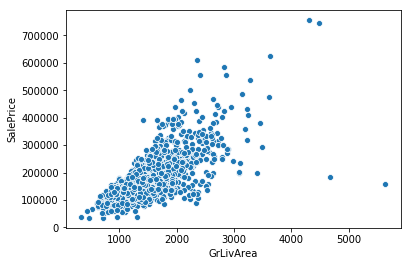

In [4]:
sns.scatterplot(data=trainData,x="GrLivArea",y="SalePrice")

In [5]:
outliers = ((trainData.GrLivArea > 4000) & (trainData.SalePrice < 5E5))

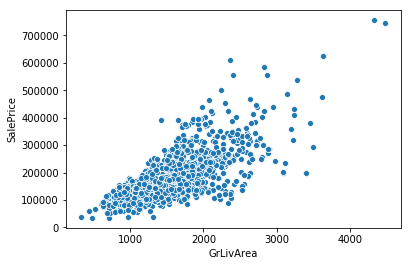

In [6]:
trainData = trainData[~(outliers)]
sns.scatterplot(data=trainData,x="GrLivArea",y="SalePrice")

Before continuing we should look at which variables are highly correlated with our SalePrice target. A correlation matrix in the form of a heatmap provides this by reading off color values from the last row of the chart while additionally providing information about correlations between variables.

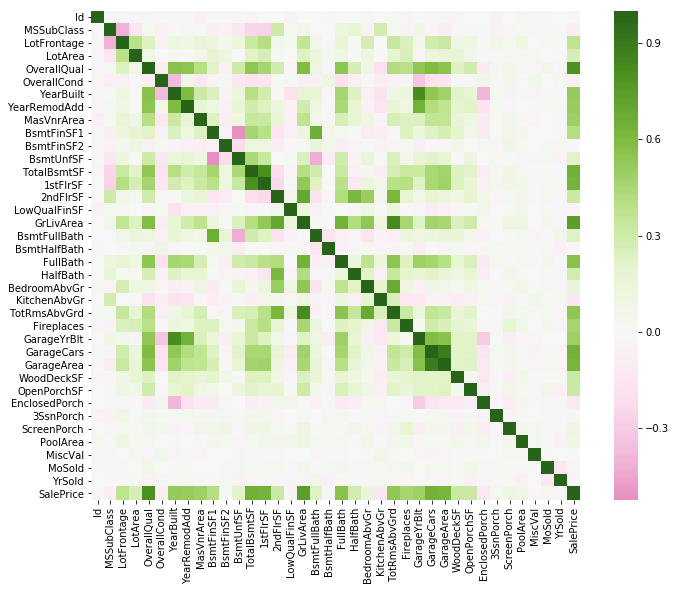

In [7]:
f, ax = plt.pyplot.subplots(figsize=(12, 9))
sns.heatmap(trainData.corr(),square=True,cmap="PiYG",center=0)

Looking at correlations between price and variables is useful for determining valuable variables to be emphasized in linear regression. Covariables need to be picked out for reducing multicollinearity.

### Strong Predictors:
 * `OverallQual`
 * `TotalBsmtSF`
 * `1stFlrSF`
 * `GrLivArea`
 * `GarageCars`
 * `GarageArea`
 * `KitchenAbvGr`
 * `MSSubClass`
 * `OverallCond`
 
### Moderate Predictors:
 * `Lot Frontage`
 * `Lot Area`
 * `YearBuilt`
 * `YearRemodAdd`
 * `MasVnrArea`
 * `BsmtFinSF1`
 * `2ndFlrSF`
 * `FullBath`
 * `Fireplaces`
 * `GarageYrBlt`
 * `EnclosedPorch`
 

### Weak Predictors:
 * `BsmtUnfSF`
 * `BsmtFullBath`
 * `BedroomAbvGr`
 * `WoodDeckSF`
 * `OpenPorchSF`

### Correlated Variables
 * `MSSubClass` - `LotFrontage`
 * `OverallQual` - `OverallCond`
 * `YearBuilt` - `YearRemodAdd`
 * Garage variables
 * Garage variables - `OverallQual`
 * Garage variables - `YearBuilt`
 * `BsmtFinSF` - `BsmtUnfSF`
 * `YearBuilt` - `EnclosedPorch`
 * `YearBuilt` - `GarageYrBuilt`
 * SF variables
 * `TotRmsAbvGrd` ~ `GrLivArea`
 * `FullBath` ~ `GrLivArea`

From this we see the most important variables seem to be `OverallQual`, `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageCars`, and `GarageArea`. We should pay extra attention to these later before training the model.
Of these, we see that the pairs (`TotalBsmtSF`, `1stFlrSF`) and (`GarageCars`,`GarageArea`) are highly correlated. This is expected, as the basement and first floor are matched to the size of the foundation, and the number of cars that can fit in a garage is going to be dependent on how big the garage is.

In [26]:
impCols = ["OverallQual","TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageCars", "GarageArea", "MSSubClass",
          "KitchenAbvGr","OverallCond"]

Before checking for missing data, see what the documentation has to say about each column and convert null values to their actual indicator. This will be packed into a function in order to pipeline when making predictions on test data. Here we list the columns transformed:
* Alley: no alley
*  Bsmt\*: no basement
* FireplaceQu: no fireplace
* Garage\*: no garage
    + expect missing values for GarageYrBlt
* PoolQC: no pool
* Fence: no fence
* MiscFeature: no such item as an elevator, tennis court, second garage, etc...

In [8]:
def nullfill(in_df):
    df = in_df.copy()
    df.Alley = df.Alley.fillna("None")
    df.BsmtQual = df.BsmtQual.fillna("None")
    df.BsmtCond = df.BsmtCond.fillna("None")
    df.BsmtExposure = df.BsmtExposure.fillna("None")
    df.BsmtFinType1 = df.BsmtFinType1.fillna("None")
    df.BsmtFinType2 = df.BsmtFinType2.fillna("None")
    df.FireplaceQu = df.FireplaceQu.fillna("None")
    df.GarageType = df.GarageType.fillna("None")
    df.GarageFinish = df.GarageFinish.fillna("None")
    df.GarageQual = df.GarageQual.fillna("None")
    df.GarageCond = df.GarageCond.fillna("None")
    df.PoolQC = df.PoolQC.fillna("None")
    df.Fence = df.Fence.fillna("None")
    df.MiscFeature = df.MiscFeature.fillna("None")
    return(df)

In [9]:
cleanData = nullfill(trainData)
cleanNa = cleanData.isnull().sum().sort_values(ascending=False)

cleanNa.head(5)

LotFrontage    259
GarageYrBlt     81
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

As expected, the `GarageYrBlt`has null values (as many as were filled from the other garage-related variables).    
`MasVnr` is short for Masonry Veneer, which should already have a value "None". Still the equality between the missing type and area seems to indicate that this should be fixed anyways.

Imputring data for the `Electrical` feature is less intuitive. We could expect the type of electrical system to vary with build date, though updates are possible. Let's see if that's true.

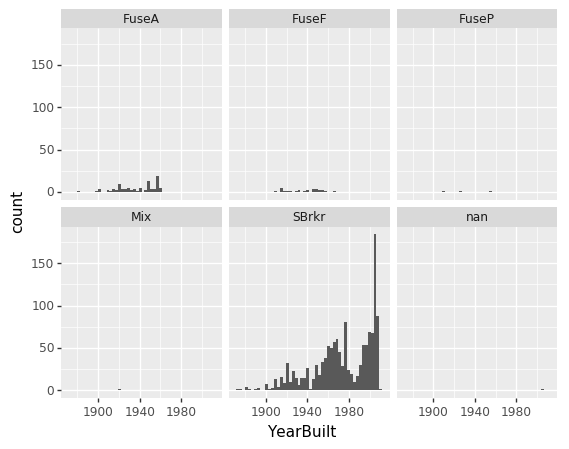

<ggplot: (-9223363256363551421)>

In [10]:
( ggplot(trainData, aes("YearBuilt"))
   + geom_histogram(bins = 50) 
   + facet_wrap("Electrical")
)

From the above plot it seems safe to impute null values in `Electrical` as "SBrkr" seeing as that type is dominant over the time period where null values exist (towards the end of year built data) as well as over the entire range of observed values for year built.

(Maybe fix this graph to be proportion rather than raw count)

In [11]:
def nullfill2(in_df):
    df = nullfill(in_df)
    df.MasVnrType = df.MasVnrType.fillna("None")
    df.MasVnrArea = df.MasVnrArea.fillna(0)
    df.Electrical = df.Electrical.fillna("SBrkr")
    return(df)

In [12]:
cleanData = nullfill2(trainData)
cleanNa = cleanData.isnull().sum().sort_values(ascending=False)

cleanNa.head(5)

LotFrontage    259
GarageYrBlt     81
SalePrice        0
ExterCond        0
RoofStyle        0
dtype: int64

A quick check of the test data shows that this cleaning is insufficient, and all cases should be covered. This requires going back and stepping through each class to provide a standard for null inputs.

In [13]:
cleanTest = nullfill2(testData)
testCleanNA = cleanTest.isnull().sum().sort_values(ascending=False)

testCleanNA.head(5)

LotFrontage     227
GarageYrBlt      78
MSZoning          4
Functional        2
BsmtHalfBath      2
dtype: int64

Performing the same analysis we did on the `Electrical` feature, we see that houses in this dataset predominantly have central air. This leads us to impute the `CentralAir` value as "y".

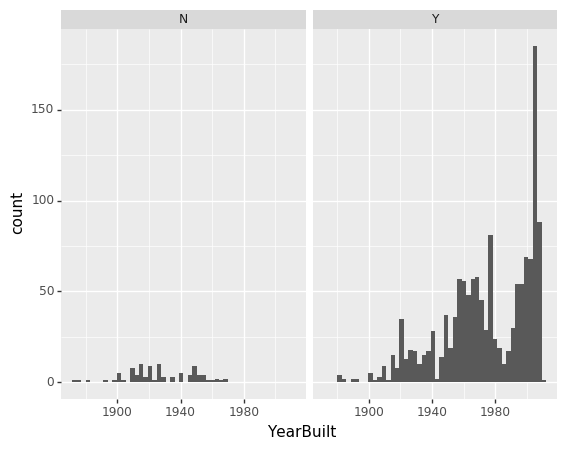

<ggplot: (8780490381267)>

In [14]:
( ggplot(trainData, aes("YearBuilt"))
   + geom_histogram(bins = 50) 
   + facet_wrap("CentralAir")
)

We are still left with uncertainty as to what to do with the `GarageYrBlt` and `LotFrontage` features. 

Concerning the `GarageYrBlt` variable: The plot below shows that the garage is largely built with the house and of those that were not, there is no immediate correlation. Imputing a value of 0 may be dangerous for a continuous variable in a linear regression type model. Additionally, our correlation matrix above shows that this variable may explain some variance in the data so it may not be wise to delete this variable. Consequently, it seems like a good choice to impute values of 0 if we commit to only use decision tree-type models. 

`LotFrontage` values could mean that the lot doesn't actually have any direct street access. In depth analysis could involve looking at these specific houses to determine what is going on, or seeing correlation with alley access. From there we can impute a value of zero or the modal value for each neighborhood. During the model training phase these two methods will be compared.

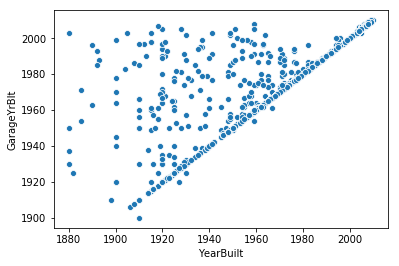

In [15]:
sns.scatterplot(data=trainData,x="YearBuilt",y="GarageYrBlt")

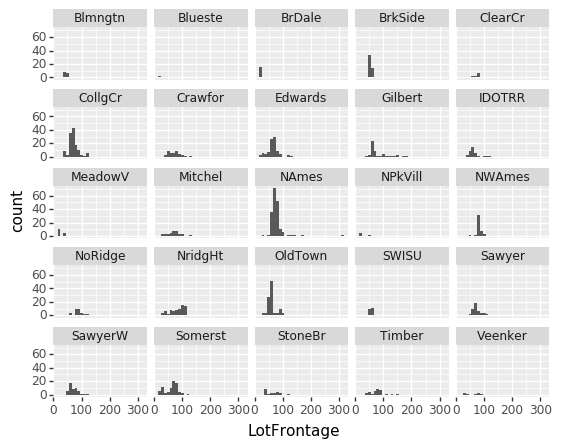

<ggplot: (8780490301665)>

In [16]:
(ggplot(trainData,aes("LotFrontage"))
  + geom_histogram(bins=30)
  + facet_wrap("Neighborhood")
)

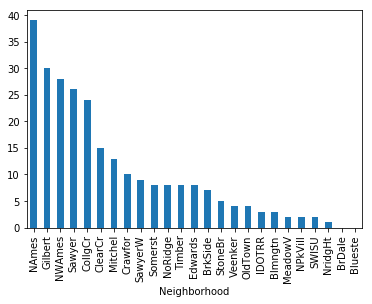

In [17]:
frontageNull = trainData.LotFrontage.isnull().groupby(trainData["Neighborhood"]).sum()
frontageNull.sort_values(ascending=False).plot.bar()

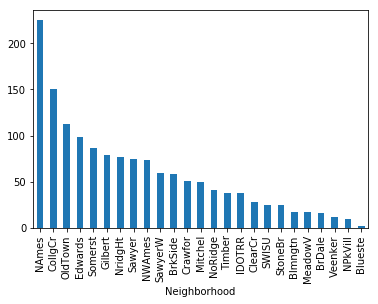

In [18]:
totalByNeighborhood = trainData.groupby("Neighborhood").count().Id

totalByNeighborhood.sort_values(ascending=False).plot.bar()

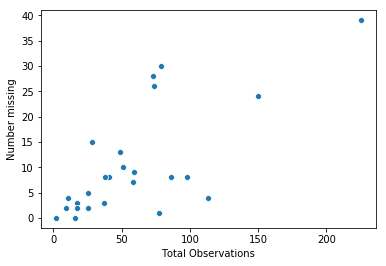

In [19]:
fig1 = sns.scatterplot(x=totalByNeighborhood,y=frontageNull)
fig1.set(xlabel="Total Observations",ylabel="Number missing")
fig1

For the MSZoning and Utilities features we impute on the modal value for each neighborhood, creating a dictionary. We create an additional dictionary to compare our different `LotFrontage` imputations as well.

In [20]:
zoning = trainData.groupby("Neighborhood").MSZoning.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
utilities = trainData.groupby("Neighborhood").Utilities.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
frontage = trainData.groupby("Neighborhood").LotFrontage.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()

In [ ]:
# values that null is filled with "None"
fillNone = ["Alley","BsmtQual","BsmtCond","MasVnrType","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageType","GarageFinish","GarageQual",
           "GarageCond","PoolQC","Fence","MiscFeature","MasVnrType"]

# For categorical data, it is 
fillZero = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","2ndFlrSF","GrLivArea",
           "MasVnrArea","GarageArea","GarageCars", "GarageYrBlt"]

def imputeVals0(in_df):
    df = in_df.copy()
    for i in fillNone:
        df[i] = df[i].fillna("None")
    for i in fillZero:
        df["null_%s" % (i)] = df[i].isnull()                           # mark which zeros are imputed
        df[i] = df[i].fillna(0)
    df.Electrical = df.Electrical.fillna("SBrkr")
    df.Functional = df.Functional.fillna("Typ")                        # Documentation instructs to assume "typical" unless otherwise noted
    df.CentralAir = df.CentralAir.fillna("Y")
    df["null_LotFrontage"] = df.LotFrontage.isnull()
    df.LotFrontage = df.LotFrontage.fillna(0)                             
    df.MSZoning = df.MSZoning.fillna(df.Neighborhood.map(zoning))
    df.Utilities = df.Utilities.fillna(df.Neighborhood.map(utilities))
    df.KitchenQual = df.KitchenQual.fillna("Po")                      #one house missing kitchen data
    df.SaleType = df.SaleType.fillna("Oth")                           # only one missing value, fill the already defined "other"
    df.Exterior1st = df.Exterior1st.fillna("Other")
    df.Exterior2nd = df.Exterior2nd.fillna("Other")                  # the same house is responsible for the missing exterior 1st and 2nd, other is predefined
    df = df.drop(columns=["Id"])
    return(df)

def imputeVals1(in_df):
    df = in_df.copy()
    for i in fillNone:
        df[i] = df[i].fillna("None")
    for i in fillZero:
        df["null_%s" % (i)] = df[i].isnull()
        df[i] = df[i].fillna(0)
    df.Electrical = df.Electrical.fillna("SBrkr")
    df.Functional = df.Functional.fillna("Typ")                        
    df.CentralAir = df.CentralAir.fillna("Y")
    df.LotFrontage = df.LotFrontage.fillna(df.Neighborhood.map(frontage))            # This is the only line different in these two functions, maybe a more elegant solution is possible               
    df.MSZoning = df.MSZoning.fillna(df.Neighborhood.map(zoning))
    df.Utilities = df.Utilities.fillna(df.Neighborhood.map(utilities))
    df.KitchenQual = df.KitchenQual.fillna("Po")                     
    df.SaleType = df.SaleType.fillna("Oth")                           
    df.Exterior1st = df.Exterior1st.fillna("Other")
    df.Exterior2nd = df.Exterior2nd.fillna("Other")                 
    df = df.drop(columns=["Id"])
    return(df)

In [ ]:
impData0 = imputeVals0(trainData)
impData1 = imputeVals1(trainData)

print("There are %d nulls left in the training data" % impData1.isnull().sum().sum())             # Check if both axes can be summed in one function call
print("There are %d nulls left in the testing data" % imputeVals0(testData).isnull().sum().sum())

# Feature Engineering

Here we go through the necessary steps of checking the assumptions of most models as well as transformations to optimize model performance. It is worth noting that on a decision tree-type model, renormalization will have little effect.

The plot below shows that the `SalePrice` target variable deviates greatly from a normal distribution. We can attribute this partially to the lower bound of 0 and no upper bound to the value of a home, causing a positive skew.

It is worth noting that the kurtosis produced by the default kurtosis function is the excess kurtosis where the normal distribution produces a value zero.

Skew: 1.881
Kurtosis: 6.523


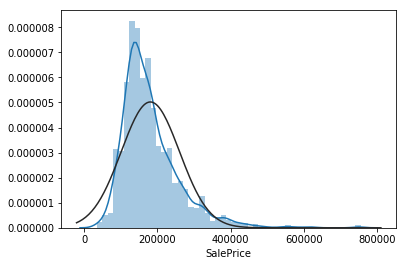

In [21]:
sns.distplot(trainData["SalePrice"], fit=norm)
print("Skew: %.3f" % (trainData.SalePrice.skew()))
print("Kurtosis: %.3f" % (trainData.SalePrice.kurtosis()))

The scipy function `normaltest` uses these metrics to produce a statistic that is the sum of the squared skew and kurtosis as well as a p-value for a 2-sided $\chi^2$ test of normality. Below, the p-value indicates an unfathomably small probability that this sample was drawn from a normal distribution. To improve this, a bit of engineering is in order. A $log$ transformation tempers positive skewness while normalization often improves model performance.

In [22]:
from scipy.stats import normaltest

normaltest(trainData.SalePrice.values)

NormaltestResult(statistic=609.3375615896337, pvalue=4.830918297944473e-133)

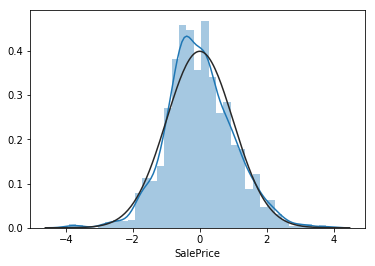

In [23]:
normedPrice = np.log(trainData.SalePrice)
sp_mean = np.mean(normedPrice)
sp_std = np.std(normedPrice)
normedPrice = (normedPrice - sp_mean) / sp_std

sns.distplot(normedPrice, fit=norm)

In [24]:
normaltest(normedPrice)

NormaltestResult(statistic=25.299623223996917, pvalue=3.208164433338703e-06)

This visually looks much better and the $\chi^2$ test shows greatly improved results but it still fails test of normality. More engineering may be necessary to improve performance in the future.

Recall we earmarked some features as being important predictors of our target feature:

In [27]:
impCols

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'MSSubClass',
 'KitchenAbvGr',
 'OverallCond']

Good model performance can depend on the distribution of these values so we renormalize these as well before training. The normaltest performed for the target variable shows that; of our variables of interest; `TotalBsmtSF`, `1stFlrSF`, and `GrLivArea` are all in need of renormalization. Before performing renormalization it's important to note that our imputation procedure for continuous values included imputing zero, particularly for `TotalBsmtSF` where we recognized that houses don't necessarily have basements.  Blindly repeating our previous treatment of `SalePrice` will yield an error because $log(0)$ is undefined. 

In [ ]:
normedCols = impData0[impCols]

for col in impCols:
    print("%s pval: %.3e" % (col, normaltest(normedCols[col].values)[1]))

In [ ]:
temp = np.log(normedCols["1stFlrSF"])
temp_mean, temp_std = (np.mean(temp),np.std(temp))
temp = (temp - temp_mean)/temp_std
normedCols["1stFlrSF"] = temp

flr1_mean, flr1_std = (temp_mean, temp_std)          # save these values for the transform in the pipeline

normaltest(temp)

In [ ]:
temp = np.log(normedCols["GrLivArea"])
temp_mean, temp_std = (np.mean(temp),np.std(temp))
temp = (temp - temp_mean)/temp_std
normedCols["GrLivArea"] = temp

gflr_mean, gflr_std = (temp_mean, temp_std)    

normaltest(temp)

In [ ]:
normedCols.loc[normedCols.TotalBsmtSF > 0, "TotalBsmtSF"] = np.log(normedCols.TotalBsmtSF)      # this must be done with loc

In [ ]:
sns.distplot(normedCols.loc[normedCols.TotalBsmtSF > 0, "TotalBsmtSF"], fit=norm)

In [ ]:
print("Skew: %.3f" % normedCols.loc[normedCols.TotalBsmtSF > 0, "TotalBsmtSF"].skew())
print("Kurtosis: %.3f" % normedCols.loc[normedCols.TotalBsmtSF > 0, "TotalBsmtSF"].kurtosis())
normaltest(normedCols.loc[normedCols.TotalBsmtSF > 0, "TotalBsmtSF"].values)

Despite the poor p-value the distribution of nonzero values is visually improved. We forgo renormalization to avoid overlapping these values with imputed zeros.

Now wrap this up in a function for pipelining.

In [ ]:
def scalePrice(in_df):
    df = in_df.copy()
    df.SalePrice = np.log(trainData.SalePrice)
    df.SalePrice = (df.SalePrice - sp_mean)/sp_std
    return(df)

# This function will be necessary to extract predicted values
def invPrice(df):
    return( np.exp((df*sp_std)+sp_mean))

def featureFix(in_df):
    df = in_df.copy()
    temp = np.log(df["1stFlrSF"])
    temp = (temp - flr1_mean)/flr1_std
    df["1stFlrSF"] = temp
    temp = np.log(df["GrLivArea"])
    temp = (temp - gflr_mean)/gflr_std
    df["GrLivArea"] = temp
    df.loc[df.TotalBsmtSF > 0, "TotalBsmtSF"] = np.log(df.TotalBsmtSF)
    return(df)

For numerical data that is categorical, make sure that the type is String instead of Int

In [ ]:
trainData.columns

In [ ]:
catCol = ["MSSubClass","OverallCond","YrSold","MoSold","GarageYrBlt","YearBuilt","YearRemodAdd"]

def makeStr(in_df):
    df = in_df.copy()
    for col in catCol:
        df[col] = df[col].astype(str)
    return(pd.get_dummies(df))                          # convert to one-hot encoding

In [ ]:
def split_xy(in_df):
    y = in_df.SalePrice
    x = in_df.drop(columns=["SalePrice"])
    return(x,y)